In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

디스크 아이디별로 train valid split을 한 뒤에 randomforest를 돌려본다.

In [2]:
data = pd.read_csv('../ssd_data/final_data/final_MB1.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,6653.0,100.0,0.0,97.0,12707.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,4.976439e+10,99.0,3.939800e+10,0.0
1,2019-01-02,6653.0,100.0,0.0,97.0,12731.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.034821e+10,99.0,3.956458e+10,0.0
2,2019-01-03,6653.0,100.0,0.0,97.0,12755.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.082254e+10,99.0,3.973763e+10,0.0
3,2019-01-04,6653.0,100.0,0.0,97.0,12779.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.121309e+10,99.0,3.990997e+10,0.0
4,2019-01-05,6653.0,100.0,0.0,97.0,12803.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.157860e+10,99.0,4.008257e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71551,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
71552,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
71553,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
71554,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [3]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1
# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(242, 1)

In [4]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [5]:
import random
random.seed(42)

# 194개씩 랜덤하게 선택
healthy_disk_194 = random.sample(healthy_disk_list, 194)
failure_disk_194 = random.sample(failure_disk_list, 194)

print(len(healthy_disk_194))
print(len(failure_disk_194))

# 194개에서 155/39 개로 validation set 구축
healthy_disk_155 = random.sample(healthy_disk_194,155) #train set
healthy_disk_39 = list(set(healthy_disk_194) - set(healthy_disk_155)) #validation set

failure_disk_155 = random.sample(failure_disk_194, 155) #train set
failure_disk_39 = list(set(failure_disk_194) - set(failure_disk_155)) #validation set

print('train_healthy_count:', len(healthy_disk_155))
print('train_failure_count:', len(failure_disk_155))

print('val_healthy_count:', len(healthy_disk_39))
print('val_failure_count:',len(failure_disk_39))
# 48개씩 랜덤하게 선택
healthy_disk_48 = random.sample(list(set(healthy_disk_list) - set(healthy_disk_194)), 48)
failure_disk_48 = list(set(failure_disk_list) - set(failure_disk_194))

print('test_healthy_count:',len(healthy_disk_48))
print('test_healthy_count:',len(failure_disk_48))

194
194
train_healthy_count: 155
train_failure_count: 155
val_healthy_count: 39
val_failure_count: 39
test_healthy_count: 48
test_healthy_count: 48


In [6]:
H_disk_194 = data[data['disk_id'].isin(healthy_disk_194)]
F_disk_194 = data[data['disk_id'].isin(failure_disk_194)]

H_disk_155 = data[data['disk_id'].isin(healthy_disk_155)]
F_disk_155 = data[data['disk_id'].isin(failure_disk_155)]

H_disk_39 = data[data['disk_id'].isin(healthy_disk_39)]
F_disk_39 = data[data['disk_id'].isin(failure_disk_39)]

H_disk_48 = data[data['disk_id'].isin(healthy_disk_48)]
F_disk_48 = data[data['disk_id'].isin(failure_disk_48)]

# train set, validation set, test set 생성
final_train_set = pd.concat([H_disk_194,F_disk_194],ignore_index=True,axis=0) #validation set으로 최적의 epoch 찾은 후, 해당 epoch으로 다시 training 시킬 예정
train_set = pd.concat([H_disk_155,F_disk_155],ignore_index=True,axis=0)
val_set = pd.concat([H_disk_39,F_disk_39],ignore_index=True,axis=0)
test_set = pd.concat([H_disk_48,F_disk_48],ignore_index=True,axis=0)

In [12]:
# H_disk_194와 F_disk_194의 shape 출력
print("H_disk_194의 shape:", H_disk_194.shape)
print("F_disk_194의 shape:", F_disk_194.shape)

# H_disk_155와 F_disk_155의 shape 출력
print("H_disk_155의 shape:", H_disk_155.shape)
print("F_disk_155의 shape:", F_disk_155.shape)

# H_disk_39와 F_disk_39의 shape 출력
print("H_disk_39의 shape:", H_disk_39.shape)
print("F_disk_39의 shape:", F_disk_39.shape)

# H_disk_48와 F_disk_48의 shape 출력
print("H_disk_48의 shape:", H_disk_48.shape)
print("F_disk_48의 shape:", F_disk_48.shape)

H_disk_194의 shape: (35114, 35)
F_disk_194의 shape: (22324, 35)
H_disk_155의 shape: (28055, 35)
F_disk_155의 shape: (17943, 35)
H_disk_39의 shape: (7059, 35)
F_disk_39의 shape: (4381, 35)
H_disk_48의 shape: (8688, 35)
F_disk_48의 shape: (5430, 35)


In [13]:
# feature와 label 구분
final_X_train = final_train_set.drop(columns=['disk_id','index','label'])
X_train = train_set.drop(columns=['disk_id','index','label'])
X_val = val_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

final_y_train = final_train_set['label']
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

In [14]:
# Random Forest 모델 생성
rf = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150)

In [15]:
rf.fit(final_X_train,final_y_train)

RandomForestClassifier(max_depth=20, n_estimators=150)

In [18]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = rf.predict(X_test)

print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("F1-score on Test Set:", f1_score(y_test, y_pred))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9285309533928319
F1-score on Test Set: 0.6182368520620507
Precision on Test Set: 0.6791354945968412
Recall on Test Set: 0.5673611111111111


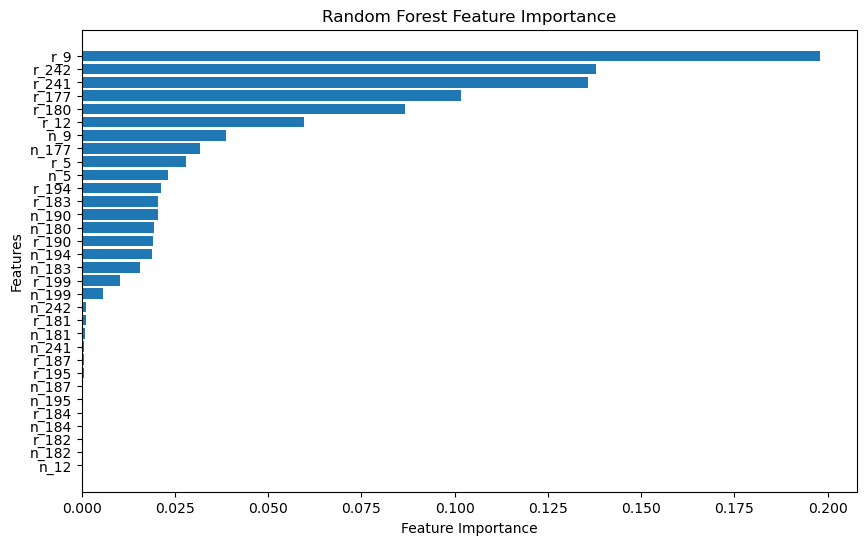

In [21]:
# Feature Importance 시각화
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

In [18]:
rf.predict(X_test)

array([0., 0., 0., ..., 1., 1., 1.])

In [3]:
# 데이터셋 준비 (X: 특성, y: 타겟)
X = data.drop(['disk_id', 'index', 'label'], axis=1)
y = data['label']

In [4]:
# 데이터를 train/test 세트로 나누기 (비율: 80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Random Forest 모델 생성
rf = RandomForestClassifier()

In [6]:
# Grid Search를 위한 매개변수 그리드 설정
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [7]:
# Grid Search 객체 생성
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=['accuracy', 'f1', 'precision', 'recall'], refit='accuracy')

In [8]:
# Grid Search 수행
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             refit='accuracy',
             scoring=['accuracy', 'f1', 'precision', 'recall'])

In [9]:
# Grid Search 결과 출력
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_accuracy'], results['params']):
    print("Accuracy: {:.4f} with: {}".format(mean_score, params))

Accuracy: 0.9945 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9949 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9950 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.9944 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.9946 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9946 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.9936 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.9936 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.9940 with: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
A

In [10]:
# 최적의 하이퍼파라미터로 훈련된 최종 모델을 가져옴
best_model = grid_search.best_estimator_

In [11]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = best_model.predict(X_test)

In [12]:
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("F1-score on Test Set:", f1_score(y_test, y_pred))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9960871995528228
F1-score on Test Set: 0.9802259887005649
Precision on Test Set: 0.9879003558718861
Recall on Test Set: 0.9726699369306236


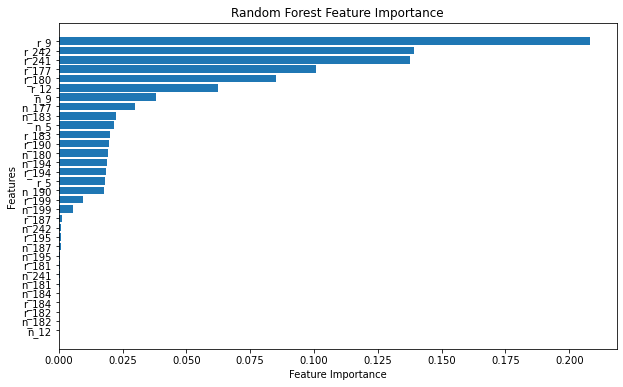

In [13]:
# Feature Importance 시각화
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

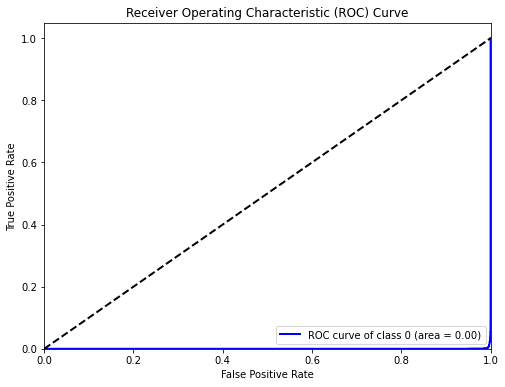

In [18]:
# AUC Curve 시각화
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], best_model.predict_proba(X_test)[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])  # You can add more colors for more classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()